# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

/home/gizmo/anaconda3/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

def make_ground_feature(side_initial, coord):
    side = 'right' if side_initial == 'r' else 'left'
    col_name = side + '-' + coord
    nose_col_name = 'nose-' + coord
    ground_col_name = 'grnd-' + side_initial + coord
    asl.df[ground_col_name] = asl.df[col_name] - asl.df[nose_col_name]

for side_initial in ['r', 'l']:
    for coord in ['x', 'y']:
        make_ground_feature(side_initial, coord)

In [5]:
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [6]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
# The following gets the features in a different order, thus compromising the test.
# features_ground = [f for f in list(asl.df) if f.startswith('grnd')]
features_ground

['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

In [7]:
#show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [8]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [9]:
len(training.words)

112

In [10]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

In [11]:
# len(training.get_word_Xlengths('CHOCOLATE')[0]) # 49

In [12]:
# sum(training.get_word_Xlengths('CHOCOLATE')) # 49

#### NOTES FOR MYSELF: clarifications on the data structure

Cf. also [this](https://discussions.udacity.com/t/get-word-xlengths-please-explain/246977/5) and [this other](https://discussions.udacity.com/t/whats-the-difference-between-x-length-and-sequences-in-training-data/240244/4) thread. All this seemed quite confusing to a lot of people, including myself.

The first element of the tuple is made up of concatenated 'sequences' of observations. Now, what is a 'sequence'? It seems to be the set of values observed for the features used when building the training set (in this case, features_ground). But only for one frame. So a sequence is a time frame really. And each occurrence of the word in the training set consists of a number of frames, hence of sequences. --- That is precisely what the second element of the tuple gives: the length (i.e. number of frames = sequences) of each training example.

To confirm this, let's examine the training data:

In [13]:
# awk -F ',' '$3=="CHOCOLATE"' train_words.csv
# video,speaker,word,startframe,endframe # headers, not shown really
# 81,woman-2,CHOCOLATE,19,35
# 82,woman-1,CHOCOLATE,37,56
# 198,man-1,CHOCOLATE,19,30

So there are three instances of "CHOCOLATE" in the training set. Each consists of `endframe - startframe + 1` frames, which is exactly 17, 20, and 12 respectively. We can get this result directly with:

In [14]:
# awk -F ',' '$3=="CHOCOLATE" {print $5-$4+1}' train_words.csv

To sum up: imagine a matrix where each column is a 'sequence' (i.e. a time frame) and each row a feature. Then we would have something like this (this is just a made-up example):

| | seq1 | seq2 | seq3 | seq4 | seq5 | seq6 | seq7 | seq8 | seq9 |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| feat1 | 12 | 1 | 0.3 | 5 | 89 | 9 | 43 | 7 | 0.2 |
| feat2 | 5 | 3 | 8 | 4 | 70 | 5 | 30 | 10 | 3 |
| feat3 | 3 | 2 | 0 | 9 | 50 | 4 | 15 | 0 | 3 |
| feat4 | 16 | -1 | 8.7 | 3.2 | 23 | 3 | 20 | 0.4 | 1 |

This is the data for one occurrence of a specific word. In the image below, taken from [The HTK Book](http://htk.eng.cam.ac.uk/docs/docs.shtml) (Chapter 1.2, p. 5) and annotated by myself, each numbered row is a matrix like the one above.

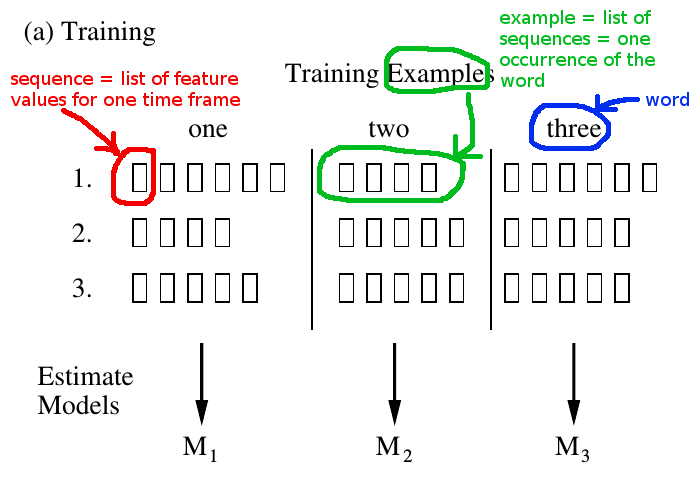

In [15]:
from IPython.display import Image
Image("hmm_training.png", width=400, height=200)

Testing my hypothesis on another word:

In [16]:
# print(training.get_word_Xlengths('FISH')[1]) # [11, 13]

# Same result with:
# awk -F ',' '$3=="FISH" {print $5-$4+1}' train_words.csv # 11, 13

**END OF CLARIFICATION NOTES FOR MYSELF**

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [17]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,31.216447,157.036848
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,2.006318,104.026144
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,12.895536,118.505134


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [18]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean  
video frame                                                   
98    0          113        9      -12      119   164.661438  
      1          113        9      -12      119   164.661438  
      2          113        9      -12      119   164.661438  
      3          113        9      -12      119   164.661438  
      4          113        9      -12      119   164.661438

##### Try it!

In [19]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,15.080360,36.572749,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,17.328941,27.117393,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,15.050938,29.320655,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


#### Normalized Cartesian coordinates

In [20]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_to_norm = [side + '-' + coord for side in ['right', 'left'] \
                    for coord in ['x', 'y']]
features_to_norm

['right-x', 'right-y', 'left-x', 'left-y']

In [21]:
features_norm = ['norm-' + side_initial + coord \
                  for side_initial in ['r', 'l'] \
                  for coord in ['x', 'y']]
features_norm

['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

In [22]:
def make_aux_cols(feature_name):
    """Add columns for mean and std."""
    mean_col_name = feature_name + "-mean"
    std_col_name = feature_name + "-std"
    asl.df[mean_col_name] = \
        asl.df['speaker'].map(df_means[feature_name])
    asl.df[std_col_name] = asl.df['speaker'].map(df_std[feature_name])

In [23]:
def normalise_feature(feature_name, norm_feature_name):
    mean_col_name = feature_name + "-mean"
    std_col_name = feature_name + "-std"
    asl.df[norm_feature_name] = \
        (asl.df[feature_name] - asl.df[mean_col_name]) /\
         asl.df[std_col_name]

In [24]:
for i in range(len(features_to_norm)):
    make_aux_cols(features_to_norm[i])
    normalise_feature(features_to_norm[i], features_norm[i])

In [25]:
# list(asl.df)
# asl.df.columns.values.tolist() # same thing, perhaps more efficient?

In [26]:
asl.df[features_norm].head(n=10)

norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835
      5      1.153232  1.663433 -0.891199  0.741835
      6      1.153232  1.663433 -0.891199  0.741835
      7      1.153232  1.663433 -0.891199  0.741835
      8      1.153232  1.663433 -0.891199  0.741835
      9      1.153232  1.663433 -0.891199  0.741835

#### Polar coordinates

In [27]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

#features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

def make_polar_coords(side):
    side_initial = side[0]
    r_col_name = 'polar-' + side_initial + 'r'
    r_theta_name = 'polar-' + side_initial + 'theta'
    x_col_name = 'grnd-' + side_initial + 'x'
    y_col_name = 'grnd-' + side_initial + 'y'
    asl.df[r_col_name] = np.sqrt(np.square(asl.df[x_col_name]) + \
                                 np.square(asl.df[y_col_name]))
    # Swap x and y (cf. instructions)
    asl.df[r_theta_name] = np.arctan2(asl.df[x_col_name], asl.df[y_col_name])

In [28]:
for side in ['left', 'right']:
    make_polar_coords(side)

In [29]:
features_polar = ['polar-rr', 'polar-rtheta',
                  'polar-lr', 'polar-ltheta']
# Don't use, because different order.
# features_polar = [f for f in list(asl.df) if f.startswith('polar')]
features_polar

['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [30]:
# asl.df.columns.values.tolist()

In [31]:
# asl.df[features_polar].head(n=10)

#### Delta features

In [32]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

# features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

def make_delta(side, coord):
    side_initial = side[0]
    col_name = side + '-' + coord
    # On normalised version
    #col_name = 'norm' + '-' + side_initial + coord
    delta_col_name = 'delta-' + side_initial + coord
    asl.df[delta_col_name] = asl.df[col_name].diff().fillna(value=0)

In [33]:
for side in ['left', 'right']:
    for coord in ['x', 'y']:
        make_delta(side, coord)

In [34]:
# features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
# features_delta = [f for f in list(asl.df) if f.startswith('delta')]
features_delta = ['delta-' + side_initial + coord \
                   for side_initial in ['r', 'l'] \
                   for coord in ['x', 'y']]
features_delta

['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [35]:
# asl.df.columns.values.tolist()

In [36]:
asl.df[features_delta].head(10)

delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    0           0.0       0.0       0.0       0.0
      1           0.0       0.0       0.0       0.0
      2           0.0       0.0       0.0       0.0
      3           0.0       0.0       0.0       0.0
      4           0.0       0.0       0.0       0.0
      5           0.0       0.0       0.0       0.0
      6           0.0       0.0       0.0       0.0
      7           0.0       0.0       0.0       0.0
      8           0.0       0.0       0.0       0.0
      9           0.0       0.0       0.0       0.0

#### Custom features

In [37]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

In [38]:
# asl.df['delta-rx'].describe()

In [39]:
# asl.df['polar-rr'].describe()

In [40]:
# asl.df['polar-rtheta'].describe()

In [41]:
# TODO define a list named 'features_custom' for building the training set

# features_custom_1 = ['rx-lx', 'ry-ly']
# features_custom_2 = ['delta-rx-lx', 'delta-ry-ly',
#                      'delta-nose-x', 'delta-nose-y']
# features_custom_3 = ['scaled-delta-rx', 'scaled-delta-ry',
#                      'scaled-delta-lx', 'scaled-delta-ly']
# features_custom_4 = ['scaled-rx-lx', 'scaled-ry-ly']
# features_custom_5 = ['scaled-delta-rx-lx', 'scaled-delta-ry-ly',
#                      'scaled-delta-nose-x', 'scaled-delta-nose-y']
# features_custom_6 = ['norm-polar-rr', 'norm-polar-rtheta',
#                      'norm-polar-lr', 'norm-polar-ltheta']

##### Difference between coordinates of right and left hand in same frame

In [42]:
def make_hands_diff(coord):
    """Make column for difference between right and left 'coord' (x or y)."""
    diff_col_name = 'r' + coord + '-l' + coord
    right_col_name = 'right-' + coord
    left_col_name = 'left-' + coord
    asl.df[diff_col_name] = asl.df[right_col_name] - asl.df[left_col_name]

for coord in ['x', 'y']:
    make_hands_diff(coord)

In [43]:
features_custom_1 = ['r' + coord + '-' + 'l' + coord \
                     for coord in ['x', 'y']]
features_custom_1

['rx-lx', 'ry-ly']

In [44]:
# asl.df.columns.values.tolist()

##### Delta between nose coordinates and between difference in hands coordinates, between consecutive frames

In [45]:
def make_delta(feature):
    delta_col_name = 'delta-' + feature
    asl.df[delta_col_name] = asl.df[feature].diff().fillna(value=0)

In [46]:
feat_for_delta = ['nose-' + coord for coord in ['x', 'y']] + \
                  features_custom_1
feat_for_delta

['nose-x', 'nose-y', 'rx-lx', 'ry-ly']

In [47]:
for feat in feat_for_delta:
    make_delta(feat)

In [48]:
# list(asl.df)

In [49]:
features_custom_2 = ['delta-' + f for f in feat_for_delta]
features_custom_2

['delta-nose-x', 'delta-nose-y', 'delta-rx-lx', 'delta-ry-ly']

##### Scaled version of original delta features

In [50]:
features_delta # older

['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [51]:
def scale_feature(feature_name):
    scaled_feature_name = 'scaled-' + feature_name
    feat = asl.df[feature_name]
    feat_min = feat.min()
    feat_max = feat.max()
    asl.df[scaled_feature_name] = (feat - feat_min) / (feat_max - feat_min)

In [52]:
for feat in features_delta:
    scale_feature(feat)

In [53]:
# asl.df.columns.values.tolist()

In [54]:
features_custom_3 = ['scaled-' + f for f in features_delta]
features_custom_3

['scaled-delta-rx', 'scaled-delta-ry', 'scaled-delta-lx', 'scaled-delta-ly']

##### Scaled version of difference between right and left hand coordinates, in same frame

In [55]:
for feat in features_custom_1:
    scale_feature(feat)

In [56]:
# asl.df.columns.values.tolist()

In [57]:
features_custom_4 = ['scaled-' + f for f in features_custom_1]
features_custom_4

['scaled-rx-lx', 'scaled-ry-ly']

##### Scaled version of delta between nose coordinates and between difference in hands coordinates, between consecutive frames

In [58]:
for feat in features_custom_2:
    scale_feature(feat)

In [59]:
# list(asl.df)

In [60]:
features_custom_5 = ['scaled-' + f for f in features_custom_2]
features_custom_5

['scaled-delta-nose-x',
 'scaled-delta-nose-y',
 'scaled-delta-rx-lx',
 'scaled-delta-ry-ly']

In [61]:
# for feat in [f for f in list(asl.df) if f.startswith('scaled')]:
#     print(feat)
#     print(asl.df[feat].describe())
#     print()

##### Normalised polar coordinates

In [62]:
# Recompute means and std dfs to include the new features.
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

In [63]:
features_polar

['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [64]:
features_custom_6 = ['norm-' + f for f in features_polar]
features_custom_6

['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']

In [65]:
for i in range(len(features_polar)):
    make_aux_cols(features_polar[i])
    normalise_feature(features_polar[i], features_custom_6[i])

In [66]:
# list(asl.df)

In [67]:
# for feat in [f for f in list(asl.df) if f.startswith('norm')]:
#     print(feat)
#     print(asl.df[feat].describe())
#     print()

#### Some bookkeeping for later

Collect all feature name sets.

In [68]:
suffixes = ['ground', 'delta', 'norm', 'polar']
all_feature_set_names = ['features_' + suffix for suffix in suffixes]
all_feature_set_names

['features_ground', 'features_delta', 'features_norm', 'features_polar']

In [69]:
custom_feature_set_names = ['features_custom_' + str(i) \
                            for i in range(1, 7)]
custom_feature_set_names

['features_custom_1',
 'features_custom_2',
 'features_custom_3',
 'features_custom_4',
 'features_custom_5',
 'features_custom_6']

In [70]:
all_feature_set_names += custom_feature_set_names
all_feature_set_names

['features_ground',
 'features_delta',
 'features_norm',
 'features_polar',
 'features_custom_1',
 'features_custom_2',
 'features_custom_3',
 'features_custom_4',
 'features_custom_5',
 'features_custom_6']

In [71]:
all_features = {f_set_name: eval(f_set_name) \
                for f_set_name in all_feature_set_names}

from pprint import pprint
pprint(all_features)

{'features_custom_1': ['rx-lx', 'ry-ly'],
 'features_custom_2': ['delta-nose-x',
                       'delta-nose-y',
                       'delta-rx-lx',
                       'delta-ry-ly'],
 'features_custom_3': ['scaled-delta-rx',
                       'scaled-delta-ry',
                       'scaled-delta-lx',
                       'scaled-delta-ly'],
 'features_custom_4': ['scaled-rx-lx', 'scaled-ry-ly'],
 'features_custom_5': ['scaled-delta-nose-x',
                       'scaled-delta-nose-y',
                       'scaled-delta-rx-lx',
                       'scaled-delta-ry-ly'],
 'features_custom_6': ['norm-polar-rr',
                       'norm-polar-rtheta',
                       'norm-polar-lr',
                       'norm-polar-ltheta'],
 'features_delta': ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly'],
 'features_ground': ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'],
 'features_norm': ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly'],
 'features_polar': ['polar-

In [72]:
# Save the data to avoid having to reprocess everything over and over again.
# pickle.dump(asl, open('asl.pickle', 'wb'))
# pickle.dump(all_features, open('features.pickle', 'wb'))

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** These are the features I computed:

In [73]:
for i in range(1, 7):
    print('features_custom_{}:'.format(i))
    print(eval('features_custom_{}'.format(i)))
    print()

features_custom_1:
['rx-lx', 'ry-ly']

features_custom_2:
['delta-nose-x', 'delta-nose-y', 'delta-rx-lx', 'delta-ry-ly']

features_custom_3:
['scaled-delta-rx', 'scaled-delta-ry', 'scaled-delta-lx', 'scaled-delta-ly']

features_custom_4:
['scaled-rx-lx', 'scaled-ry-ly']

features_custom_5:
['scaled-delta-nose-x', 'scaled-delta-nose-y', 'scaled-delta-rx-lx', 'scaled-delta-ry-ly']

features_custom_6:
['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']



My custom features can be broken down into:

- **Difference in x and y between the two hands in a single frame** (`features_custom_1`) and **scaled version** (`features_custom_4`). While these feature sets may seem redundant as they are already implicitly present in our original feature set (in the set of `ground` features), it may still be relevant to explicitly account for the relative position of the two hands in a single frame. Scaling brings differences to a common scale, for fairer comparison.

- **Deltas (differences between two consecutive frames) for: the difference in x and y between the two hands in a single frame; and x and y for the nose** (`features_custom_2`). And **scaled versions** of these variables (`features_custom_5`). While the nose movement might turn out not be a good feature - since I assume most of the signing is performed with the hands - the head, and hence the nose, may sometimes also be involved in some signs. Better knowledge of ASL would be helpful in deciding the relevance of these features. On the other hand, the delta from frame to frame for the relative position of the two hands is potentially relevant.

- **Scaled versions of the original delta features** (`features_custom_3`): scaling may help the learning process by bringing features to a common scale. Rescaling is the simplest form of normalisation. Normalisation aims at bringing variables to comparable scales or to the same scale. Rescaling simply reduces the range of values of a feature to [0, 1] or [-1, 1] (cf. [Wikipedia on Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling)). My understanding is that its effect on the mean and the standard deviation, while obvious, is less systematic than that of normalisation proper (which results in zero mean and unit variance).

- **Normalised versions of the polar coordinates** (`features_custom_6`). The same as for the Cartesian coordinates: normalisation cancels out the effects of variation due to speakers' physical attributes.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [74]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.026s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using **Gaussian hidden Markov models (HMM)**.   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [75]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states,
                        n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [76]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #2
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [77]:
features_ground # not very good on 5 hidden states

['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

In [78]:
features_polar # good on 5 hidden states!

['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [79]:
#features_polar_norm = [f for f in list(asl.df) if \
#                      f.startswith('norm-polar-')]
features_custom_6
# Excellent on 5 states!

['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']

In [80]:
features_delta # Much better than ground with 5 hidden states.
# Make sure the features are actually in the df.
# [f for f in features_delta if f in list(asl.df)]

['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [81]:
features_custom_1 # not very good

['rx-lx', 'ry-ly']

In [82]:
features_custom_3[:2] # not bad!

['scaled-delta-rx', 'scaled-delta-ry']

In [83]:
features_custom_3[2:4]
# This is incredibly high, but the visualisation is kind of odd. I can't figure out how to make sense of it. Besides, it doesn't make much intuitive sense that the movement of the nose on its own have such strong discriminative power.

['scaled-delta-lx', 'scaled-delta-ly']

In [84]:
features_mix_1 = features_custom_3[2:4] + features_custom_6
features_mix_1

['scaled-delta-lx',
 'scaled-delta-ly',
 'norm-polar-rr',
 'norm-polar-rtheta',
 'norm-polar-lr',
 'norm-polar-ltheta']

In [85]:
my_testword = 'FISH'
model, logL = train_a_word(my_testword, 4, [features_custom_6[0]]) # Experiment here with different parameters

# On 'FISH', with 4 hidden states, the rest of polar features seem to be useless according to the visualisation. However, including all of them does increase the training log-likelihood.

show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FISH is 4
hidden state #0
mean =  [-0.31957122]
variance =  [ 0.00105774]

hidden state #1
mean =  [-0.51797486]
variance =  [ 1000.]

hidden state #2
mean =  [-0.40396863]
variance =  [ 0.00360136]

hidden state #3
mean =  [-0.51797516]
variance =  [ 0.00090992]

logL = 56.04904862745215


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [86]:
%matplotlib inline

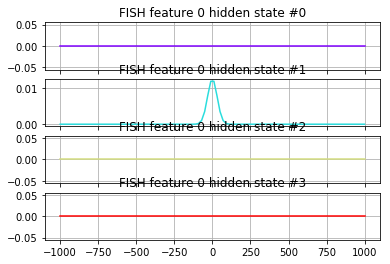

In [87]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components,
                                sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".\
                         format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
# for i in range(len(features_polar)):
#     print('feature {}: {}'.format(i, features_polar[i]))
    
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [88]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [89]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".\
          format(cv_train_idx, cv_test_idx))# view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


In [90]:
# word_sequences

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [91]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

#### SelectorCV

In [92]:
from importlib import reload
import my_model_selectors
reload(my_model_selectors)

<module 'my_model_selectors' from '/home/gizmo/Documents/aind/projects/AIND-Recognizer/my_model_selectors.py'>

In [93]:
training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

In [94]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

In [95]:
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                       min_n_components=2, max_n_components=15,
                       random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.018903850999777205 seconds
Training complete for BOOK with 6 states with time 4.820177569003135 seconds
Training complete for VEGETABLE with 2 states with time 2.20780707099766 seconds
Training complete for FUTURE with 2 states with time 4.56095687400375 seconds
Training complete for JOHN with 12 states with time 49.803206816002785 seconds


#### SelectorBIC

In [96]:
# training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
# sequences = training.get_all_sequences()
# Xlengths = training.get_all_Xlengths()

In [97]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

In [98]:
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word,
                        min_n_components=2, max_n_components=15,
                        random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with \
              time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with               time 0.43762265799887246 seconds
Training complete for BOOK with 8 states with               time 2.4491110039962223 seconds
Training complete for VEGETABLE with 9 states with               time 0.8801798479980789 seconds
Training complete for FUTURE with 9 states with               time 2.6666056730027776 seconds
Training complete for JOHN with 13 states with               time 25.46044649299438 seconds


#### SelectorDIC

In [99]:
# training = asl.build_training(features_ground)
# training = asl.build_training(features_polar_norm)  # Experiment here with different feature sets defined in part 1
# sequences = training.get_all_sequences()
# Xlengths = training.get_all_Xlengths()

In [100]:
# type(sequences)

In [101]:
# sequences

In [102]:
# Xlengths

In [103]:
# sequences.keys()

In [104]:
# Xlengths.keys()

In [105]:
# sequences.keys() == Xlengths.keys() # True

In [106]:
# TODO: Implement SelectorDIC in module my_model_selectors.py

# %load_ext autoreload 
# %autoreload 2

from importlib import reload
import my_model_selectors
reload(my_model_selectors)

from my_model_selectors import SelectorDIC

In [107]:
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word,
                        min_n_components=2, max_n_components=15,
                        random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with \
              time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with               time 0.9638463849987602 seconds
Training complete for BOOK with 15 states with               time 4.9844744369984255 seconds
Training complete for VEGETABLE with 15 states with               time 4.282172243998502 seconds
Training complete for FUTURE with 15 states with               time 5.27500275499915 seconds
Training complete for JOHN with 15 states with               time 27.78664619099436 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** As Alain Biem points out in his [paper introducing the DIC model selection metric](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf), model selection in machine learning can be framed in terms of different objectives:

- If what we are after is the least complex model possible that is able to account reasonably well for the data and also generalises well to unseen data, then we are looking to optimise the so-called **bias-variance trade-off**, and we take Occam's razor - the principle of **parsimony** - as our guiding principle. This is probably the most commonly used guiding principle for model selection. **BIC** falls under this approach: it seeks to balance model fitting and model complexity, and so favours less complex models.

- If, on the other hand, in a classification setting, we are less preoccupied with model complexity, but we want to look beyond within-class statistics, a **discriminative approach** such as **DIC** is more appropriate. As pointed out by Biem, DIC has the advantage of taking into account not only the evidence in favour of each class (the probability of each class generating its data points under the model), but also what Biem calls 'anti-evidence' ('the capacity of the model to generate data belonging to competing classes').

Concretely, given its formulation, **DIC** is expected (and shown by Biem) to **perform better than BIC** as a model selection criterion in a classification setting. However, this improved performance comes at the cost of **potentially increased complexity**: models selected on the basis of DIC might have more parameters than those selected via BIC. Also, the **computation of DIC is more expensive than that of BIC**, since each model trained on a class must be evaluated on all the remaining classes as well. When there are few classes the additional time is negligible, but in a setting with a large number of classes, such as ours (112 words in total), this cost can become more significant.

Finally, **cross-validation (CV)** is not a model selection criterion per se, but simply a technique that can be used in conjuction with any model selection criterion, for optimising model hyper-parameters (i.e. parameters set by hand, not the ones the model learns on the training data). In our case, we are using CV with log-likelihood as a selection criterion. CV is good practice when there is not enough data to afford a proper validation set. While performing CV may seem a waste of time, it is actually an essential technique for getting more reliable estimates of the criterion that is being optimised: indeed, hyper-parameter optimisation should always be performed on a validation set, not on the training set, since the value we get on the training set for the metric we are optimising on the same training set is not a reliable estimate of what we are likely to get on an unseen dataset.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [108]:
# autoreload for automatically reloading changes
%load_ext autoreload
%autoreload 2

from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 156.896s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [109]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word,
                               n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [110]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


In [111]:
# test_set.df

,video,speaker,word,startframe,endframe
0,2,woman-1,JOHN,7,20
1,2,woman-1,WRITE,23,36
2,2,woman-1,HOMEWORK,38,63
3,7,man-1,JOHN,22,39
4,7,man-1,CAN,42,47
5,7,man-1,GO,48,56
6,7,man-1,CAN,62,73
7,12,woman-2,JOHN,9,15
8,12,woman-2,CAN,19,24
9,12,woman-2,GO,25,34


In [112]:
#test_set.wordlist

In [113]:
# Number of tokens to classify
#len(test_set.wordlist)

In [114]:
# Number of tokens to classify
# item = token
# test_set.num_items

In [115]:
# sentence = video, really
# Compare with the df (test_set.df).
# And word index seems to mean token index in test_set taken as a continuous sequence of tokens. Cf. output of test_set.sentences_index.
# test_set.sentences_index

In [116]:
# np.array(test_set.get_item_sequences(5)).shape

In [117]:
# test_set.get_item_Xlengths(5)

In [118]:
# TODO implement the recognize method in my_recognizer
# %load_ext autoreload
# %autoreload 2

# from my_recognizer import recognize
# from asl_utils import show_errors

In [119]:
# probabilities, guesses = recognize(models, test_set)
# show_errors(guesses, test_set)

In [120]:
#probabilities[0]

In [121]:
# logLs = np.array(list(probabilities[0].values()))

In [122]:
# sum(np.exp(logLs))

# This was to check that the actual probabilities do sum to 1, but the above gives 0 (or virtually 0). Check this (https://sourceforge.net/p/ghmm/mailman/message/822668/):

# "the log-likelihoods in ghmm are based on the natural logarithm so the reverse function is just the exponential:

# l = loglikelihood(something)
# x = math.exp(l)

# Then x will be a probability in the range [0.0,1.0] - at least theoretically. The whole reason for using the log-scale is that even for moderately sized models and sequence lenghts the likelihoods get too small to be represented. In other words, the transformation given above might very well produce an underflow error, in which case all x would come out as 0.0.

# Examples:
# >>> math.exp(-20)
# 2.0611536224385579e-09  <- works
# >>> math.exp(-100)
# 3.7200759760208361e-44  <- works
# >>> math.exp(-1000)
# 0.0                     <- underflow error

# Generally it is a good idea to work on the log-scale directly unless you are sure that you won't get any values small enough to produce underflows."

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [123]:
# TODO implement the recognize method in my_recognizer
%load_ext autoreload
%autoreload 2

from my_recognizer import recognize
from asl_utils import show_errors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# TODO Choose a feature set and model selector
features = features_polar
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [125]:
# TODO Choose a feature set and model selector
features = features_ground
model_selector = SelectorCV

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: *IX CAN *CAN CAN                                              JOHN CAN GO CAN
   21: JOHN *HOMEWORK *JOHN *TELL *CAR *CAR *GO *GO                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL IX *TELL IX                                        JOHN LIKE IX IX IX
   28: JOHN *TELL IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *BILL *CORN *BILL *IX                                    JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [126]:
# TODO Choose a feature set and model selector
features = features_custom_3
model_selector = SelectorBIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *LOVE *BOOK                                              JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *MANY *TEACHER                                   JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *JOHN *APPLE *JOHN *BUY *VISIT *CHICKEN *JOHN            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *JOHN IX *MARY                                     JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *WHO *MARY                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *MARY BUY HOUSE         

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** After running the exhaustive feature set-model selector combinations on the data, I found that **`features_ground` with `SelectorCV`** got the lowest WER (0.5393), closely followed by `features_polar` with either of `SelectorBIC` and `SelectorDIC` (0.5449), and my `features_custom_3` (`['scaled-delta-rx', 'scaled-delta-ry', 'scaled-delta-lx', 'scaled-delta-ly']`) with either of `SelectorCV` and `SelectorDIC` (0.573).

`SelectorDIC` does better than the other two on some feature sets, but worse on others, which seems to point to the importance of using good features for learning.

`features_custom_3` does better (WER of 0.57-0.58) than its non-scaled version (`features_delta`) with every model selector (WER in the 0.61-0.63). This seems to confirm that feature scaling is helpful with the learning process; indeed, `features_custom_4` (`['scaled-rx-lx', 'scaled-ry-ly']`) also achieves better results than its non-scaled version `features_custom_1`. Notwithstanding, `features_norm` achieves worse results than `features_custom_3` with all model selectors, which goes to show that normalisation by itself is unable to get much out of a poor choice of features.

`features_polar` also do very well in combination with all three selectors (WER of 0.54-0.56), and, surprisingly, better than its normalised version (0.57-0.63). Again, this shows that normalisation might not always be useful.

Overall, the performance of all feature-selector combinations is rather poor (a WER of 0.5393 is the best I could get). This best-performing combination is not exempt from completely misrecognised sentences, such as: "*LOVE *ARRIVE *HOMEWORK *COAT" instead of "IX-1P FIND SOMETHING-ONE BOOK". There are differences in WER between selectors for a same set of features, but these seem rather small compared to the differences in WER between sets of features. Overall, it would seem that the choice of features has more impact on the performance of the recogniser than the choice of model selection criterion/technique; it also seems that normalisation (whether slighter, as scaling, or stronger, as standardisation) may have a positive but also, sometimes, a negative effect on the performance. In our ASL recognition setting, the features that got best results were those that described the position of each hand with respect to the nose (be it as cartesian or polar coordinates), and those that described the movement of the hands from one time frame to another. These are indeed the most likely relevant elements of an ASL sign.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [127]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 93.547s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()